# Accelerating k-nearest neighbors 600x using cuML

![kNN-example.png](img/kNN-example.png)

k-Nearest Neighbors classification is a straightforward machine learning technique that predicts an unknown obseration by using the `k` most similar known observations in the training dataset. In the second row of the example pictured above, we find the seven digits 3, 3, 3, 3, 3, 5, 5 from the training data are most similar to the unknown digit. We then use majority vote to predict that the unknown digit is a 3.
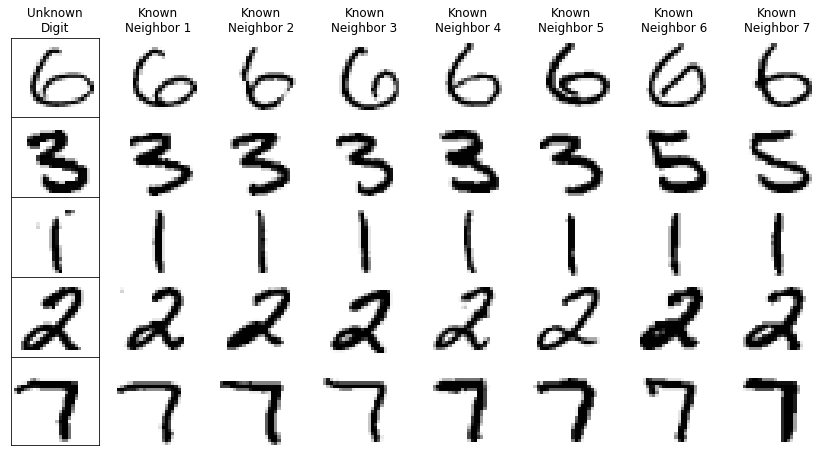

# Distance Computations
The k-nearest neighbors algorithm has no training time. All computation takes place during inference. To infer (predict) one unknown observation, we must compute how similar that unknown observation is to each of the known training observations. Mathematically, an observation is just a vector therefore similarity is the distance between two vectors. Different distance formulas exist, but the most popular is Euclidean distance. Given two observations $x_1 \in {\rm I\!R}^p$ and  $x_2 \in {\rm I\!R}^p$, the formula is $$ \text{dist} = \sqrt{ (x_1-x_2) \cdot (x_1-x_2) }$$


Thus we see if we have `p` features, then it requires `p` multiplies, `p` subtractions, `p` additions, and one square root to compute the distance between two observations. Since we must compare all the test observations with all the training observations, the total number of computations ignoring square root is `3 * p * len(train) * len(test)`. The time difference between RAPIDS cuML and Scikit-learn will be the difference it takes to make these trillions of computations.

# Speed Test on Kaggle

Besides hosting competitions, datasets, discussions, and Jupyter notebooks; Kaggle offers free GPU cloud compute. Their GPU virtual machines have one Nvidia Tesla P100 GPU and one Intel Xeon 2-core CPU. Using the famous [MNIST][1] digit image dataset, we compare the difference it takes RAPIDS cuML's kNN to predict all the unknown digits in Kaggle's MNIST digit-recognizer competition compared with Scikit-learn's kNN.

At Kaggle, we can install RAPIDS with the following code. Change `rapids=0.11` to the version you desire.

[1]: http://yann.lecun.com/exdb/mnist/

In [ ]:
import sys
!conda create -n rapids -c rapidsai/label/xgboost -c rapidsai -c nvidia -c conda-forge rapids=0.11 python=3.6 cudatoolkit=10.1 --yes
sys.path = ["/opt/conda/envs/rapids/lib"] + ["/opt/conda/envs/rapids/lib/python3.6"] + ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

Then we load the training and test data and predict using RAPIDS cuML:

In [ ]:
# RAPIDS cuML kNN model
import cudf, cuml
from cuml.neighbors import KNeighborsClassifier
train = cudf.read_csv('../input/digit-recognizer/train.csv')
test = cudf.read_csv('../input/digit-recognizer/test.csv')
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train.iloc[:,1:785], train.iloc[:,0])
y_hat = knn.predict(test)

The line of code `knn.predict(test)` does all the work.  It finishes in an incredibly fast 2.5 seconds on GPU. Next we predict with Scikit-learn:

In [ ]:
# Scikit-learn kNN model
import pandas
from sklearn.neighbors import KNeighborsClassifier
train = pandas.read_csv('../input/digit-recognizer/train.csv')
test = pandas.read_csv('../input/digit-recognizer/test.csv')
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train.iloc[:,1:785], train.iloc[:,0])
y_hat = knn.predict(test)

On CPU with Scikit-learn, the function call `knn.predict(test)` takes 25 minutes. We witness RAPIDS cuML performing 600 times faster! 

![speedup.jpg](img/speedup.jpg)

On Kaggle, the training dataset has length 42,000 and the test dataset has length 28,000. The dimension `p` of the images is 784. Therefore to predict all test images, we must perform 2.8 trillion computations! (`3 * 784 * 42000 * 28000 = 2.8e12`). The Intel Xeon 2-core CPU has clock speed 2GHz and 2 cores, so we expect it to take approximately 690 seconds. (`2.8e12 / 2e9 / 2 = 690`). The Nvidia Tesla P100 has clock speed 1GHz and 3500 CUDA cores, so we expect it to take 0.80 seconds. (`2.8e12 / 1e9 / 3500`). Therefore we expected approximately a 600x speedup.
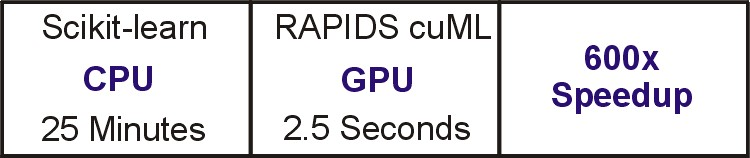

# Do More in Less Time
Since RAPIDS cuML is so fast, we now have an opportunity to explore improving our model's accuracy by performing additional tasks. Below are some ideas:
* Hyperparameter Search
* Feature Engineering and Selection
* Data Augmentation
* Ensemble with Bagging and Boosting
  
We will not explore feature engineering and selection in this blog nor bagging and boosting, but we will explore hyperparameter search and data augmentation below.

# Hyperparameter Search
The following code demonstrates a cross validation hyperparameter search. If we did this with Scikit-learn's kNN, it would literally take a few days! But with RAPIDS cuML, it only takes a few minutes!

In [ ]:
from sklearn.model_selection import KFold
for k in range(3,22,2):
    oof = np.zeros(len(train))
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    for i, (idxT, idxV) in enumerate( skf.split(train.iloc[:,1:], train.label) ):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train.iloc[idxT,1:], train.label[idxT])
        y_hat = knn.predict(train.iloc[idxV,1:])
        oof[idxV] =  y_hat[0].to_array()
    acc = ( oof==train.label.to_array() ).sum()/len(train)
    print('k =',k,'has ACC =',acc)

![hyper.png](img/hyper.png)

Validation shows us that the best kNN parameter for `k` is `k=3`. Using this parameter, we can predict all of Kaggle competition's unknown test images and submit for an accuracy of 96.9%. That's a great accuracy for 2.5 seconds of work!

![cuML.png](img/cuML.png)

The Kaggle notebook with full code to achieve 96.9% is here:
https://www.kaggle.com/cdeotte/rapids-gpu-knn-mnist-0-97
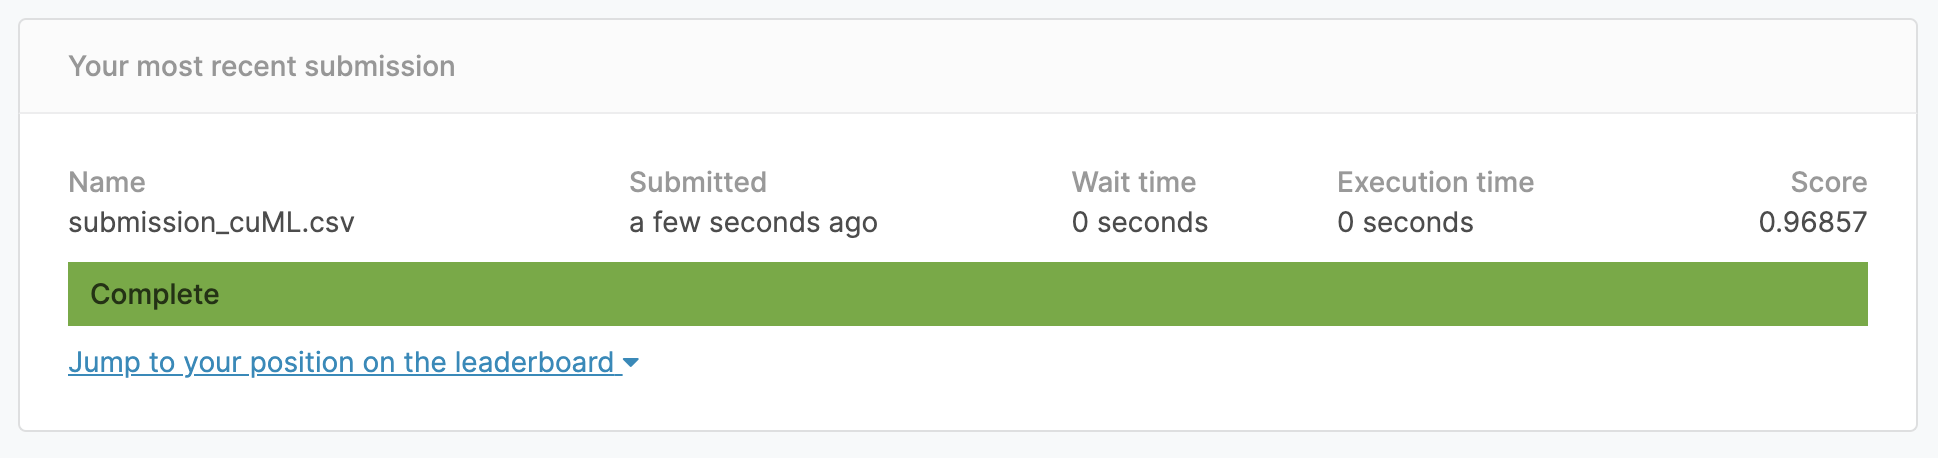
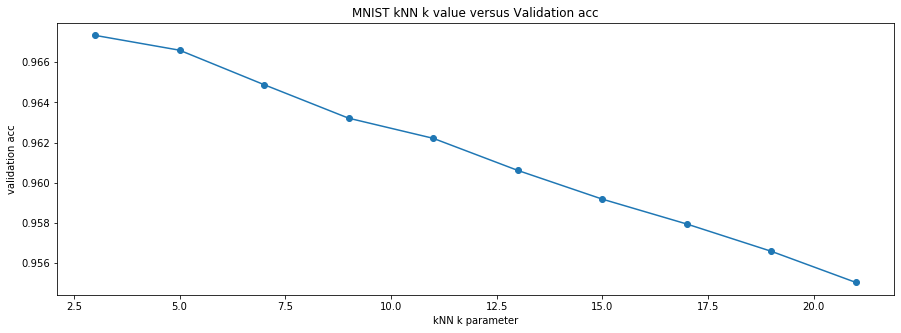

# Data Augmentation
Another way to improve the accuracy of a model is to provide the model more training data. Since a digit is still the same digit if you shift, rotate, or scale the image. We can create more training data by randomly shifting, rotating, and scaling the given training data. Kaggle provides 42,000 training images. Let's create 2 million more training images. If we added this many new training images to Scikit-learn's kNN model, it would cause the model to take days to predict the test images. With RAPIDS cuML, it will only add a minute of additional inference time!

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.10, width_shift_range=0.1, height_shift_range=0.1)
da = 50; bs=4200
train2 = np.zeros((train.shape[0]*da,train.shape[1]),dtype=np.float32)
for k,(X,Y) in enumerate( datagen.flow( train[:,1:].reshape((-1,28,28,1)), train[:,0].reshape((-1,1)) ,batch_size=bs ) ):
    train2[bs*k:bs*(k+1),1:] = X.reshape((-1,784))
    train2[bs*k:bs*(k+1),0] = Y.reshape((-1))
    if k==train2.shape[0]//bs-1: break

Next we build our RAPIDS cuML model with this new data. 

In [ ]:
knn.fit(train2[:,1:785], train2[:,0])
y_hat = knn.predict(test)

Surprisingly, RAPIDS cuML executes the call `knn.predict(test)` in an incredible 14.2 seconds. There are 2 million rows in `train2`, therefore `knn.predict(test)` was able to compute 131.7 trillion multiplies, subtractions, and additions in 14.2 seconds. Absolutely incredible! (`3 * 2e6 * 28000 * 784 = 131.7e12`). Also we see that using the additional training data achieved a higher accuracy of 98.5%. Woohoo!

![cuML_DAx50.png](img/cuML_DAx50.png)

The Kaggle notebook with full code to achieve 98.5% accuracy is here: https://www.kaggle.com/cdeotte/rapids-data-augmentation-mnist-0-985
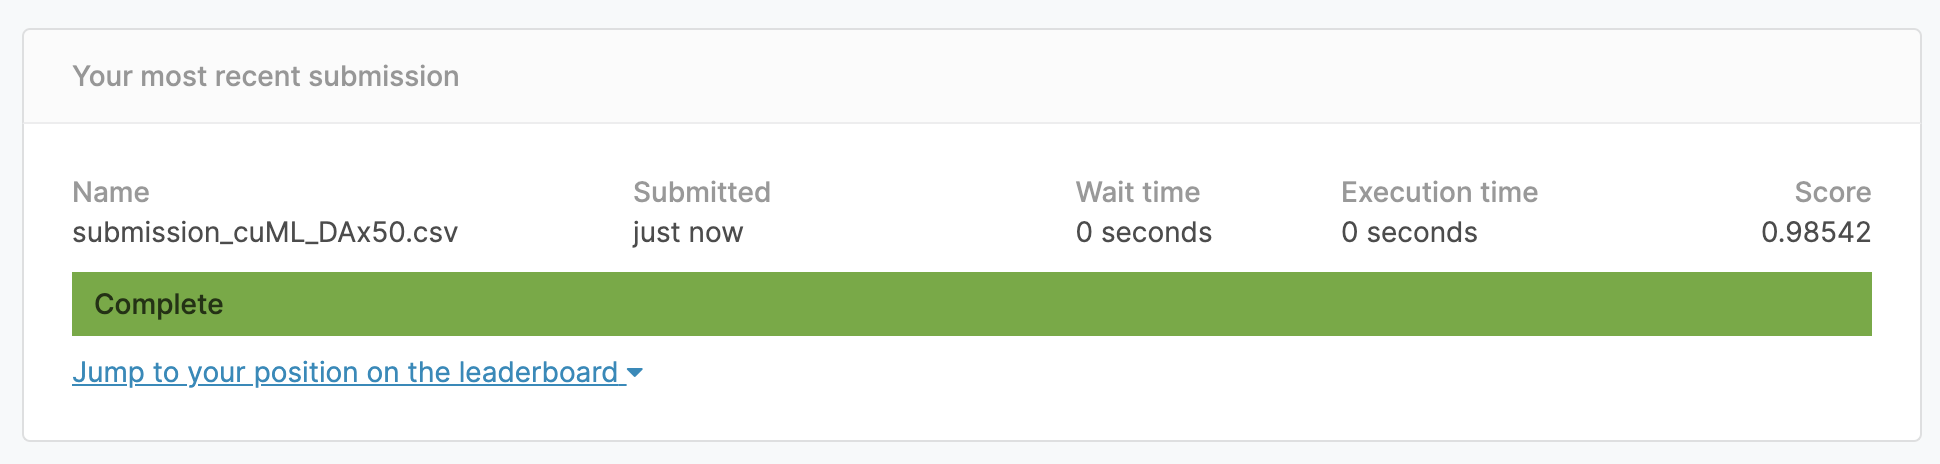